# Computing the Bottleneck Distance
### by Niklas Hellmer
### AATRN Tutorialathon, March 2021

One of the main tools to compare persistence diagrams is the bottleneck distance. 
Recall the definition: given two persistence diagrams $X$, $Y$, their **bottleneck distance** is defined as
$$
    d_B(X,Y) = \inf \limits_{M\colon X\to Y} \sup\limits_{x\in X} \|x-M(x)\|_\infty.
$$
The infimum is taken over all *matchings* $X \to Y$, i.e. all bijections. Note that points are allowed to be matched to the diagonal.

This notebook illustrates how to formulate the computation of the bottleneck distance as a combinatorial optimization problem.


In [17]:
#imports
#plotting
%matplotlib notebook
#%matplotlib widget instead of "notebook" if your're using jupyter lab
import matplotlib.pyplot as plt
import persim
from persim import plot_diagrams
from matplotlib.widgets import Slider, RadioButtons

#numpy
import numpy as np
from numpy.random import default_rng #for random persistence diagrams

#NetworkX (bipartite) graphs
import networkx as nx
from networkx.algorithms import bipartite

Let us take two small synthetic persistence diagrams for the purpose of illustration.

In [2]:
#helper method creating a random persistence diagram of card points
def randomPD(card):
    pd = np.zeros((card,2))
    pd[:,0]=rng.random(card)
    pd[:,1]=pd[:,0] + rng.random(card)
    return pd

<IPython.core.display.Javascript object>


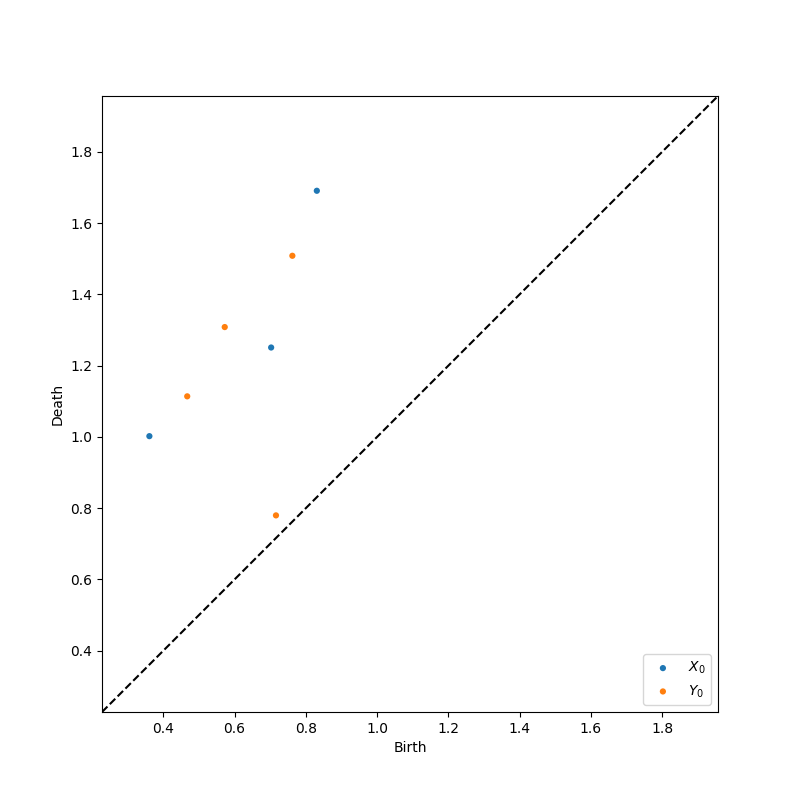

In [3]:
#generate two persistence diagrams and plot them
rng = default_rng(14)
X0 = randomPD(3)
Y0 = randomPD(4)

f,ax = plt.subplots(1,1, figsize=(8,8))
persim.plot_diagrams([X0,Y0],ax=ax, labels = ['$X_0$','$Y_0$'])
plt.show()

In [4]:
#return the projection to the diagonal of x
def DiagProj(x):
    return[(x[0]+x[1])/2]*2

<IPython.core.display.Javascript object>


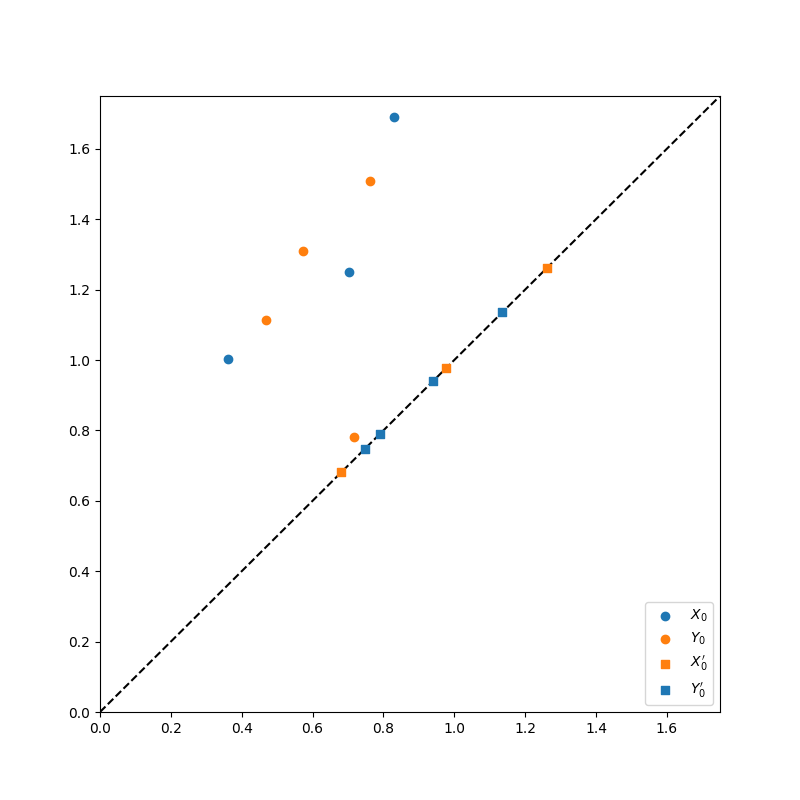

In [5]:
#X_0', Y_0' are the diagonal projections
Y0prime = np.array([DiagProj(y) for y in Y0])
X0prime = np.array([DiagProj(x) for x in X0])

#plot them
f,ax = plt.subplots(1,1, figsize=(8,8))
ax.axline((0,0), slope=1, c='k', ls ='--', zorder=-1)
ax.scatter(X0[:,0],X0[:,1], label= "$X_0$", color = "tab:blue")
ax.scatter(Y0[:,0],Y0[:,1], label= "$Y_0$", color = "tab:orange")
ax.scatter(X0prime[:,0],X0prime[:,1], label= "$X_0'$", color = "tab:orange", marker = "s")
ax.scatter(Y0prime[:,0],Y0prime[:,1], label= "$Y_0'$", color = "tab:blue", marker = "s")

ax.set_ylim((0,1.75))
ax.set_xlim((0,1.75))
ax.legend(loc = "lower right")
plt.show()

Recall that points are allowed to be matched to the diagonal. Let us set up the following notation.
The off diagonal points of $X$ are called $X_0$. Given an off-diagonal point $x=(x_1,x_2)\in X_0$, denote its **diagonal projection** by $x' = (\frac{x_1+x_2}{2},\frac{x_1+x_2}{2})$. Then we let $X_0' = \{x' \colon x\in X_0\}$. Let $Y_0$ and $Y_0'$ be defined analogously.

Now a matching $X \to Y$ corresponds to a bijection between $U:= X_0 \cup Y_0'$ and $V:= Y_0 \cup X_0'$.
In the plot below, $U$ is drawn in orange and $V$ in blue.

We now form the complete bipartite graph $G= (U\coprod V, E)$.
A *skew edge* is an edge $(x,(M(x))$, for which $x\in X_0$ and $x'\neq M(x)\in X_0'$ or $M(x)\in Y_0$ and $M(x)'\neq x\in Y_0'$.
Such a skew edge is alwys longer than the edge between an off-diagonal point and its projection to the diagonal. Hence we can drop them from $E$.

We will next look for matchings on bipartite graphs.
A set of edges $M\subset E$ is a **matching** if none of them share a vertex.
A **maximum matching** is one with the maximum number of vertices.
A **perfect matching** is one covering all vertices.

<IPython.core.display.Javascript object>


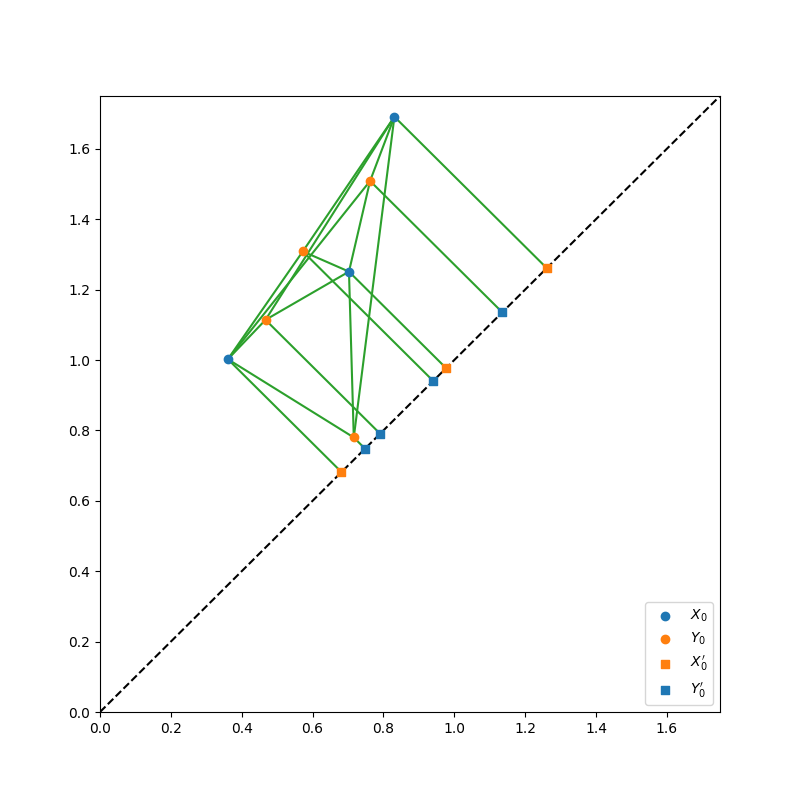

In [6]:
f,ax = plt.subplots(1,1, figsize=(8,8))
ax.axline((0,0), slope=1, c='k', ls ='--', zorder=-1)
ax.scatter(X0[:,0],X0[:,1], label= "$X_0$", color = "tab:blue")
ax.scatter(Y0[:,0],Y0[:,1], label= "$Y_0$", color = "tab:orange")
ax.scatter(X0prime[:,0],X0prime[:,1], label= "$X_0'$", color = "tab:orange", marker = "s")
ax.scatter(Y0prime[:,0],Y0prime[:,1], label= "$Y_0'$", color = "tab:blue", marker = "s")

for x in X0:
    for y in Y0:
        ax.plot((x[0],y[0]),(x[1],y[1]), color="tab:green", zorder=-1)
for x in X0:
    ax.plot((x[0],DiagProj(x)[0]),(x[1],DiagProj(x)[1]), color="tab:green", zorder=-1)
for y in Y0:
    ax.plot((y[0],DiagProj(y)[0]),(y[1],DiagProj(y)[1]), color="tab:green", zorder=-1)

ax.set_ylim((0,1.75))
ax.set_xlim((0,1.75))
ax.legend(loc = "lower right")

plt.show()

We now set up the abstract graph using the cost function $c\colon U\times V \to \mathbb{R}$,
$$
c(u,v) = \begin{cases}
    \|u-v\|_\infty & \text{if }u \in X_0 \text{ or } v \in Y_0,\\
    0 & \text{otherwise.}
\end{cases}
$$

In [7]:
U = np.append(X0,Y0prime, axis=0)
V = np.append(Y0,X0prime, axis=0)
U = [tuple(u) for u in U]
V = [tuple(v) for v in V]

B = nx.Graph()
B.add_nodes_from(U, bipartite=0)
B.add_nodes_from(V, bipartite=1)

for u in U:
    for v in V:
        if u in X0 and v in Y0:
            B.add_edge(u,v, weight= max(np.abs(u[0]-v[0]), np.abs(u[1]-v[1])))
        elif u in Y0prime and v in X0prime:
            B.add_edge(u,v, weight=0)
            
for u in X0:
    B.add_edge(tuple(u),tuple(DiagProj(u)), weight=(u[1]-u[0])/2)
for v in Y0:
    B.add_edge(tuple(v),tuple(DiagProj(v)), weight=(v[1]-v[0])/2)

We define a function to plot our bipartite graphs.

In [8]:
def plotBipartite(G, ax):
    color_map = []
    for node in G.nodes:
        color_map.append(G.nodes[node]['bipartite'])
    
    posU = dict()
    posV = dict()
    pos = dict()
    posU.update( (n, (1, i)) for i, n in enumerate(U) ) # put nodes from U at x=1
    posV.update( (n, (2, i)) for i, n in enumerate(V) ) # put nodes from V at x=2
    pos.update(posU)
    pos.update(posV)
    labels = dict()
    labels.update( (tuple(n), "$u_{}$".format(i)) for i,n in enumerate(X0))
    labels.update( (tuple(n), "$v_{}$".format(i)) for i,n in enumerate(Y0))
    labels.update( (tuple(n), "$u'_{}$".format(i)) for i,n in enumerate(X0prime))
    labels.update( (tuple(n), "$v'_{}$".format(i)) for i,n in enumerate(Y0prime))
    
    nx.draw_networkx_nodes(G, nodelist=[tuple(u) for u in X0], pos = posU, ax = ax, node_shape='o', node_color='tab:blue')
    nx.draw_networkx_nodes(G, nodelist=[tuple(v) for v in Y0], pos = posV, ax = ax, node_shape='o', node_color='tab:orange')
    nx.draw_networkx_nodes(G, nodelist=[tuple(u) for u in Y0prime], pos=posU, ax = ax, node_shape ='s', node_color='tab:blue')
    nx.draw_networkx_nodes(G, nodelist=[tuple(v) for v in X0prime], pos=posV, ax = ax, node_shape ='s', node_color='tab:orange')
    
    nx.draw_networkx_labels(G, pos, labels=labels, ax=ax)
    nx.draw_networkx_edges(G,pos, ax=ax)
    

<IPython.core.display.Javascript object>


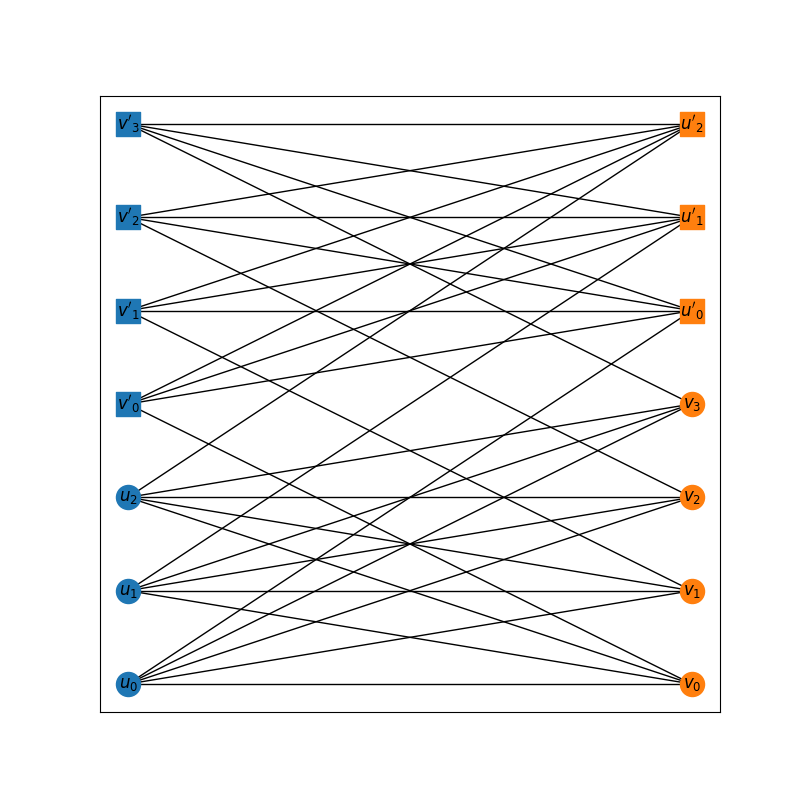

In [9]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plotBipartite(B, ax)
plt.show()

Now comes the key insight: For $\epsilon>0$, let $G_\epsilon$ be the bipartite graph with the same vertices $U\coprod V$ but only those edges which cost at most $\epsilon$. In other words, $G_\epsilon$ is the subgraph obtained from $G$ by removing edges of cost more than $\epsilon$.

#### Lemma
The bottleneck distance is the smallest $\epsilon\ge 0$ for which $G_\epsilon$ has a perfect matching (that is, one covering all vertices).

In [10]:
def getGeps(G, eps):
    G_eps = nx.Graph(G)
    for edge in G.edges:
        if G.edges[edge]['weight']>eps:
            G_eps.remove_edge(edge[0],edge[1])
            
    return G_eps

Let us investigate how the graph changes when $\epsilon$ varies.

<IPython.core.display.Javascript object>


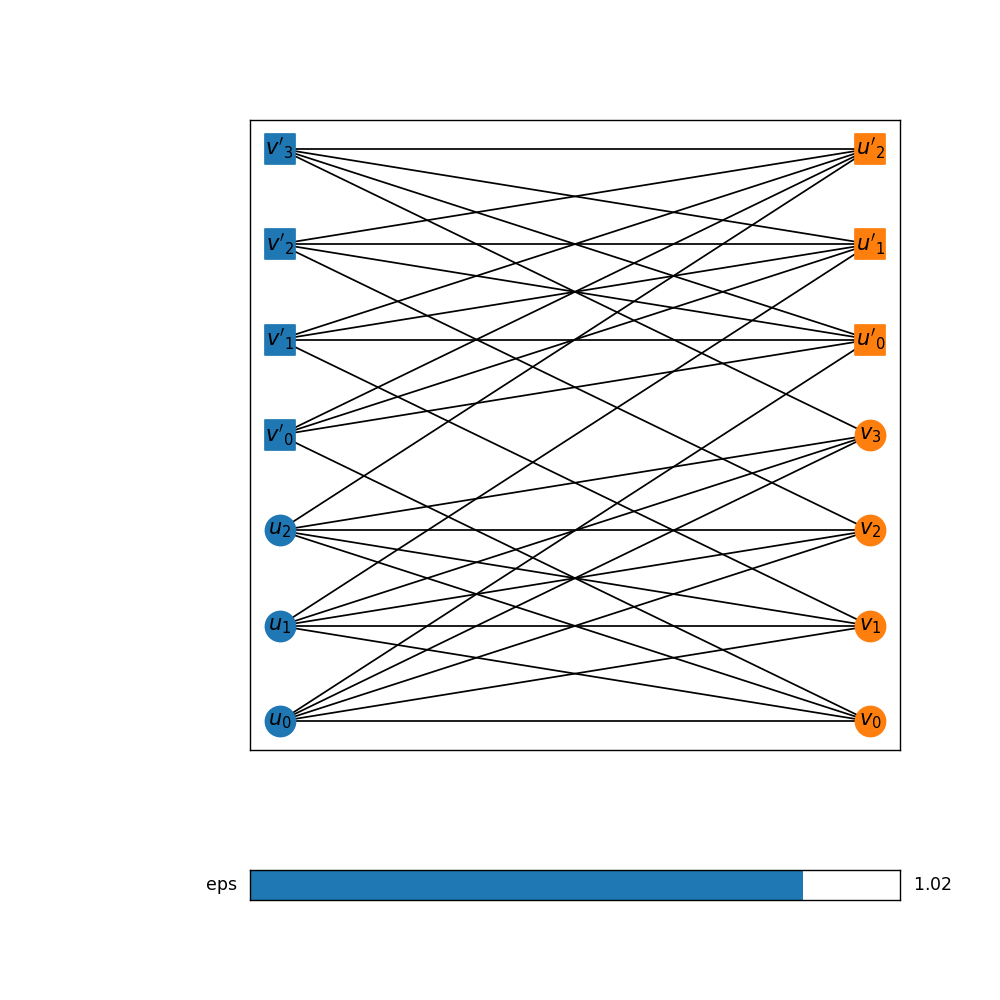

In [18]:

fig, ax2 = plt.subplots(1,1,figsize=(8,8))
plt.subplots_adjust(left=0.25, bottom=0.25)
axeps = plt.axes([0.25, 0.1, 0.65, 0.03])
seps = Slider(axeps, 'eps', 0.0, 1.2, valinit=0, valstep=0.01)

def updateGraph(val):
    ax2.clear()
    G_eps=getGeps(B,val)
    plotBipartite(G_eps, ax2)
    fig.canvas.draw_idle()
    
seps.on_changed(updateGraph)

#G_eps = getGeps(B, 0.5)
#plotBipartite(G_eps, ax)
#G_eps.nodes[U[0]]
plt.show()

<IPython.core.display.Javascript object>


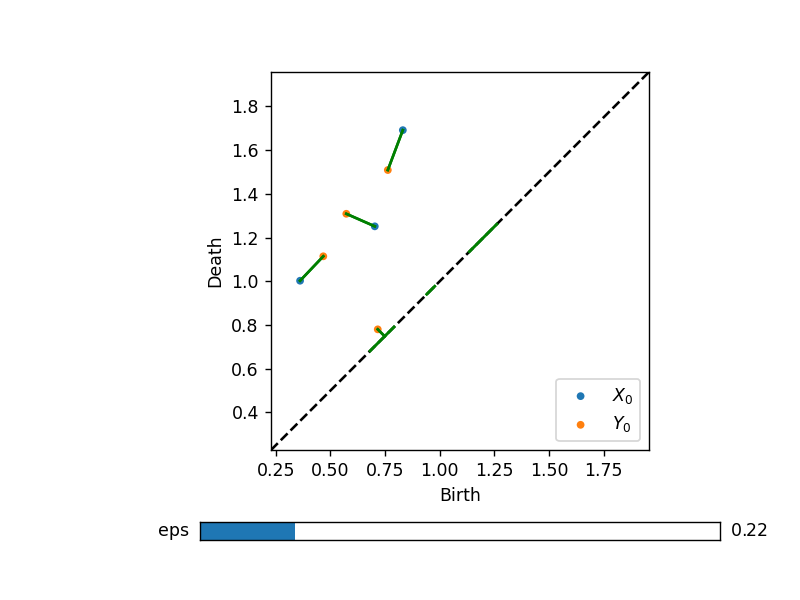

In [19]:
f,ax3 = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
axeps = plt.axes([0.25, 0.1, 0.65, 0.03])
seps2 = Slider(axeps, 'eps', 0.0, 1.2, valinit=0, valstep=0.01)

def update(val):
    ax3.clear()
    G_eps=getGeps(B,val)
    matching = nx.bipartite.hopcroft_karp_matching(G_eps, top_nodes=U)
    print(len(matching))
    persim.plot_diagrams([X0,Y0],ax=ax3, labels = ['$X_0$','$Y_0$'])
    for pair in list(matching.items()):
        ax3.plot((pair[0][0], pair[1][0]),(pair[0][1],pair[1][1]), color='green')

    fig.canvas.draw_idle()
    
seps2.on_changed(update)

#ax.plot((0.2,0.3),(0.4,0.5))
plt.show()

How can we use the above lemma? We sort the edge weights and perform a binary search. In each iteration we compute a maximum matching.

In [20]:
# sort edge weights
weights = nx.get_edge_attributes(B, "weight")
sorted_weights = np.sort(np.fromiter(weights.values(),dtype=float))

#set up binary search
L=0 #index of left endpoint
R=len(sorted_weights)-1 #index of right endpoint
while L<R:
    m = int(np.floor((R+L)/2)) # index of midpoint
    #print(L,m,R)             #uncomment to print left and right end as well as the midpoint
    G_eps = getGeps(B, sorted_weights[m])  #get the subgraph with epsilon = value at the current midpoint
    matching = nx.bipartite.hopcroft_karp_matching(G_eps, top_nodes=U) # compute the matching
    if len(matching)<len(G_eps.nodes):  # depending on the size of the matching, shrink the interval.
        L=m+1
    else:
        R=m
    
print("The bottleneck distance is", sorted_weights[L]) #display the result

The bottleneck distance is 0.18246632291920095


### Runtime analysis
To analyse the runtime complexity, denote the input size by $n=|X|+|Y|$. Note that number of edges is $O(n^2)$.

The preprocessing step of sorting the edge weights takes $O(n^2 \log(n))$.

The binary search among the edge weights takes $O(\log(n))$ iterations. In each of them, a maximum matching is computed using the Hopcroft-Karp algorithm, which takes $O(n^{2.5})$.

In conclusion, this implementation takes $O(n^{2.5} \log(n))$.

### Improving the runtime
The Hopcroft-Karp algorithm can be modified exploiting the geometric nature of the problem.
In particular, instead of performing graph searches, one can use nearest-neighbor queries.
The best currently known algorithm has complexity $O(n^{1.5}\log(n))$.

## References

Efrat, A., A. Itai, and M. J. Katz. ‘Geometry Helps in Bottleneck Matching and Related Problems’. Algorithmica 31, no. 1 (September 2001): 1–28. https://doi.org/10.1007/s00453-001-0016-8.

<div class="csl-bib-body" style="line-height: 1.35; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">Kerber, Michael, Dmitriy Morozov, and Arnur Nigmetov. ‘Geometry Helps to Compare Persistence Diagrams’. <i>ACM Journal of Experimental Algorithmics</i> 22 (15 December 2017): 1–20. <a href="https://doi.org/10.1145/3064175">https://doi.org/10.1145/3064175</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1145%2F3064175&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Geometry%20Helps%20to%20Compare%20Persistence%20Diagrams&amp;rft.jtitle=ACM%20Journal%20of%20Experimental%20Algorithmics&amp;rft.stitle=ACM%20J.%20Exp.%20Algorithmics&amp;rft.volume=22&amp;rft.aufirst=Michael&amp;rft.aulast=Kerber&amp;rft.au=Michael%20Kerber&amp;rft.au=Dmitriy%20Morozov&amp;rft.au=Arnur%20Nigmetov&amp;rft.date=2017-12-15&amp;rft.pages=1-20&amp;rft.spage=1&amp;rft.epage=20&amp;rft.issn=1084-6654%2C%201084-6654&amp;rft.language=en"></span>
</div>


Edelsbrunner, Herbert, and J. Harer. Computational Topology: An Introduction, Chapter VIII.4. Providence, R.I: American Mathematical Society, 2010.


